In [3]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
players = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_players.csv', 
                      header=None, 
                      names=['player_id', 'first_name', 'last_name', 'hand', 'birthday','country_code'])

In [6]:
players

,player_id,first_name,last_name,hand,birthday,country_code
0,100001,Gardnar,Mulloy,R,19131122.0,USA
1,100002,Pancho,Segura,R,19210620.0,ECU
2,100003,Frank,Sedgman,R,19271002.0,AUS
3,100004,Giuseppe,Merlo,R,19271011.0,ITA
4,100005,Richard Pancho,Gonzales,R,19280509.0,USA
...,...,...,...,...,...,...
54892,209858,Vladimir,Osminkin,U,NaN,RUS
54893,209859,Rostislav,Galfinger,U,20021112.0,KAZ
54894,209860,Ignacio,Buse,U,20040325.0,PER
54895,209861,Maj,Tomac,U,20010504.0,SLO


In [7]:
df = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_matches_2019.csv')

In [8]:
list(df.columns.values)

['tourney_id',
 'tourney_name',
 'surface',
 'draw_size',
 'tourney_level',
 'tourney_date',
 'match_num',
 'winner_id',
 'winner_seed',
 'winner_entry',
 'winner_name',
 'winner_hand',
 'winner_ht',
 'winner_ioc',
 'winner_age',
 'loser_id',
 'loser_seed',
 'loser_entry',
 'loser_name',
 'loser_hand',
 'loser_ht',
 'loser_ioc',
 'loser_age',
 'score',
 'best_of',
 'round',
 'minutes',
 'w_ace',
 'w_df',
 'w_svpt',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_bpSaved',
 'w_bpFaced',
 'l_ace',
 'l_df',
 'l_svpt',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_bpSaved',
 'l_bpFaced',
 'winner_rank',
 'winner_rank_points',
 'loser_rank',
 'loser_rank_points']

In [78]:
###iterate through player ids and collect features
#for pid in target_pids: ....

target_pid = 105453 #do one for now...

#instantiate a new dictionary to keep track of player stats
#this will be useful for diffing them later to create input-target pairs
pid_dict = {}

### get features from whether the target player won or lost
df2 = df[(df.loc[:,'winner_id'] == target_pid ) | (df.loc[:,'loser_id'] == target_pid)]

###create target column here
y = [1 if pid==target_pid else 0 for pid in df2.winner_id.values]
y = pd.DataFrame(data=y, columns=['target'])
df2
###switch up the dataframe to account for losses since after 
###taking target into account, we dont care about winner/loser specific columns
swapped_features = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
for swapFeat in swapped_features:
    df2.loc[(y.target.values == 0), f'w_{swapFeat}'] = df2.loc[(y.target.values == 0), f'l_{swapFeat}'] #repeat for all w/l features

### #sort by tournament date so features are sequential/time-dependant
df2 = df2.sort_values('tourney_date')
df2

###extract stats from features
segments = df2.shape[0]
features = ['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced']
x_tr = extract_stats(df2, segments, features)

### save to dictionary by PID
pid_dict.update({target_pid : x_tr})

/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice.
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/h

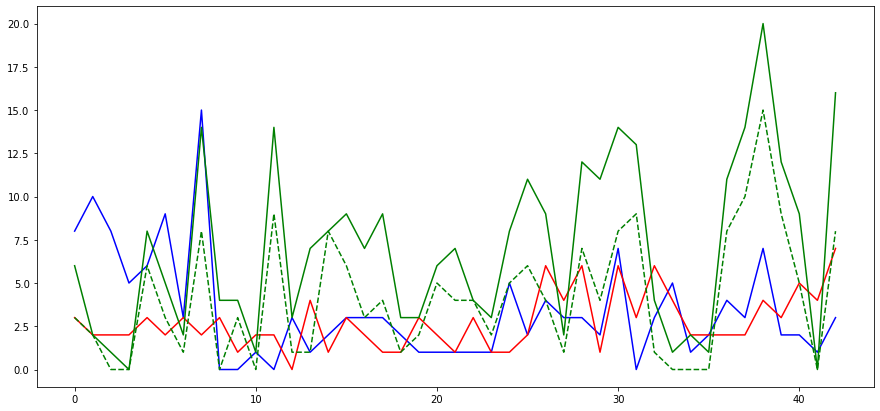

In [76]:
plt.figure(figsize=(15,7))
plt.plot(df2.w_ace.values, color='b')
plt.plot(df2.w_df.values, color='r')
plt.plot(df2.w_bpFaced.values, color='g')
plt.plot(df2.w_bpSaved.values, 'g--')
plt.show()

In [77]:
def extract_stats(df, segments, features):

    #main dataframe for storing stats
    X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)
    
    for feature in features:
    
        #time series data
        x_full = pd.Series(df[f'{feature}'].values)
        feature_name = feature[2:]
    
        for segment in range(segments):
            #take all of x until that point in time
            x = x_full[:segment+1]
            
            #compute stats on this feature
            X_tr.loc[segment, f'{feature_name}_mean'] = x.mean()
            X_tr.loc[segment, f'{feature_name}_std'] = x.std()
            X_tr.loc[segment, f'{feature_name}_max'] = x.max()
            X_tr.loc[segment, f'{feature_name}_min'] = x.min()

            X_tr.loc[segment, f'{feature_name}_mean_change_abs'] = np.mean(np.diff(x))
            X_tr.loc[segment, f'{feature_name}_abs_max'] = np.abs(x).max()
            X_tr.loc[segment, f'{feature_name}_abs_min'] = np.abs(x).min()

#             X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
#             X_tr.loc[segment, 'sum'] = x.sum()

#             X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
#             X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
#             X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
#             X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)

#             X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
#             X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
#             X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
#             X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)

#########################
        #     X_tr.loc[segment, 'trend'] = add_trend_feature(x)
        #     X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
        #     X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
        #     X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
#######################
#             X_tr.loc[segment, 'mad'] = x.mad()
#             X_tr.loc[segment, 'kurt'] = x.kurtosis()
#             X_tr.loc[segment, 'skew'] = x.skew()
#             X_tr.loc[segment, 'med'] = x.median()

            #rolling stats
#             for windows in [2, 4, 6, 8, 10, 12, 14, 16, 20, 25]:
            for windows in [2, 4, 6]:
                x_roll_std = x.rolling(windows).std().dropna().values
                x_roll_mean = x.rolling(windows).mean().dropna().values

                X_tr.loc[segment, f'{feature_name}_ave_roll_std_' + str(windows)] = x_roll_std.mean()
                X_tr.loc[segment, f'{feature_name}_std_roll_std_' + str(windows)] = x_roll_std.std()
                X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
                X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])

                X_tr.loc[segment, f'{feature_name}_ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
                X_tr.loc[segment, f'{feature_name}_std_roll_mean_' + str(windows)] = x_roll_mean.std()
                X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
                X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
                
    #fill all NaN values with 0
    X_tr = X_tr.fillna(value=0.0)
    
    return X_tr

## Model developement

In [ ]:
#XGBoost/CatBoost/LGBM

## Evaluation